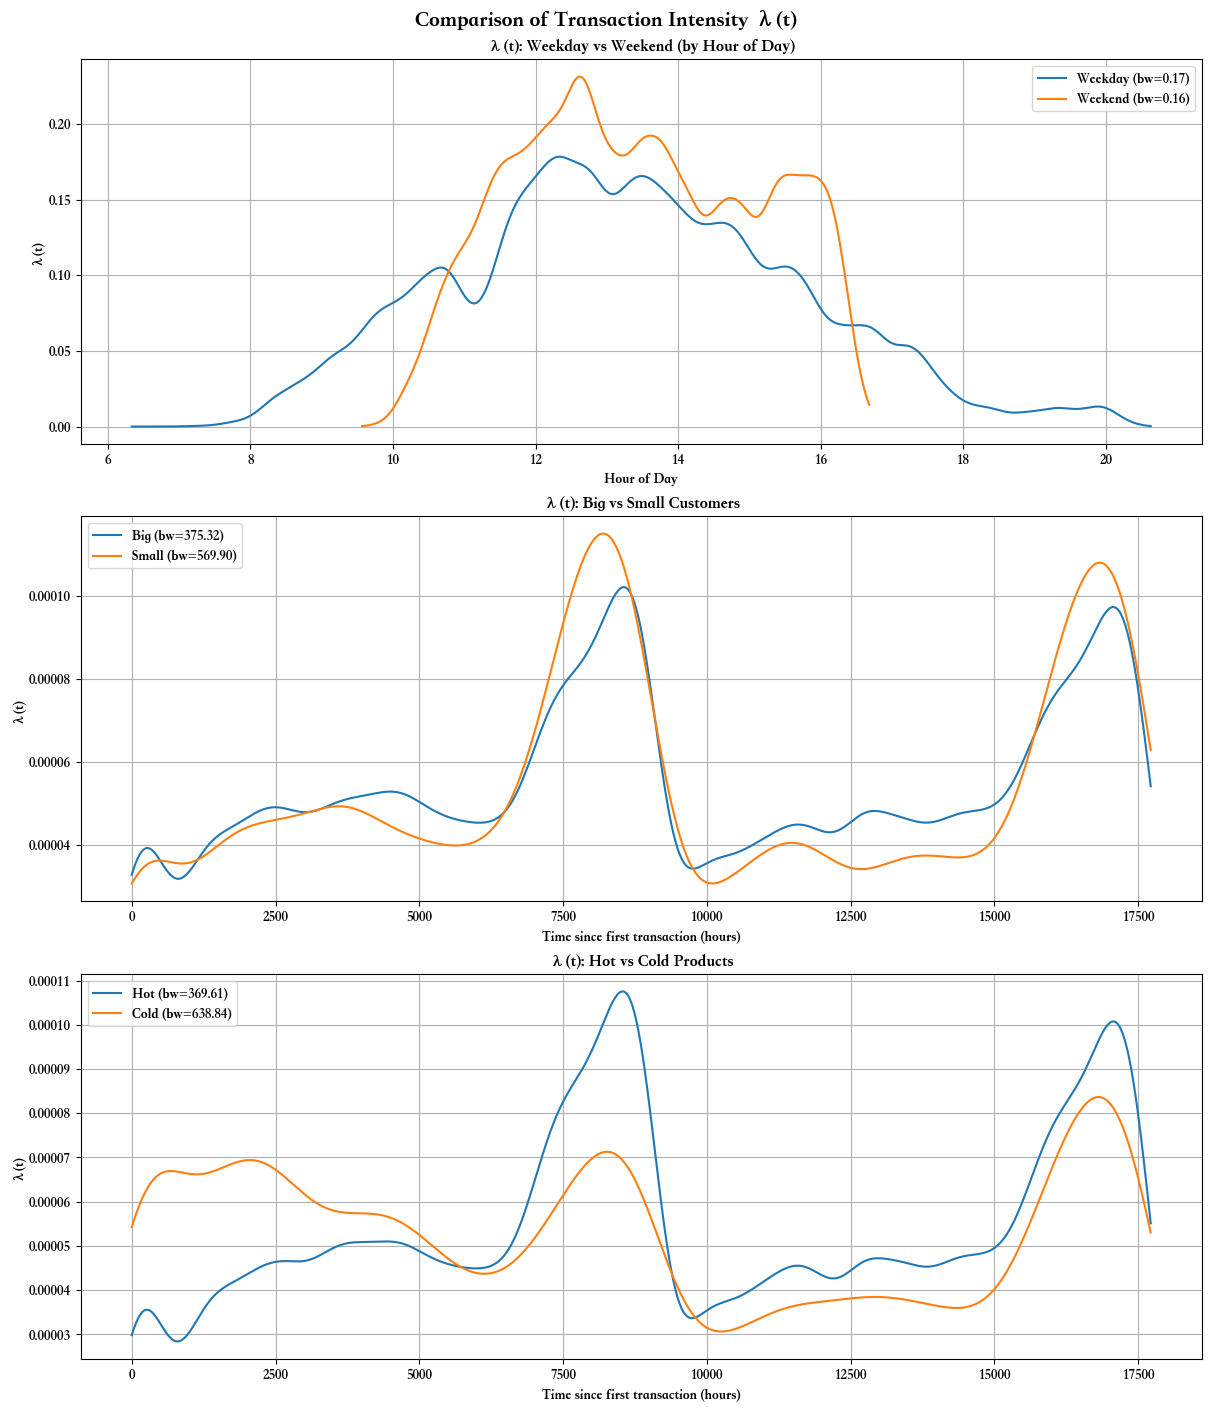

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# ====== 函数区域 ======

def silverman_bandwidth(data):
    """Silverman's rule of thumb"""
    data = np.asarray(data)
    std = np.std(data, ddof=1)
    n = len(data)
    if n <= 1 or std == 0:
        return 1.0
    return 1.06 * std * n ** (-1/5)

def kde_curve(x, bandwidth, grid_size=1000):
    """核密度估计并返回坐标和密度值"""
    x = np.asarray(x)[:, None]
    x_grid = np.linspace(min(x.flatten()), max(x.flatten()), grid_size)[:, None]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(x)
    log_dens = kde.score_samples(x_grid)
    return x_grid.flatten(), np.exp(log_dens)

def plot_lambda_subplot(ax, data_dict, title, xlabel, bandwidths):
    """绘制子图，支持多个分组曲线 + 带宽显示"""
    for label, data in data_dict.items():
        bw = silverman_bandwidth(data)
        bandwidths[label] = bw
        x_vals, y_vals = kde_curve(data, bw)
        ax.plot(x_vals, y_vals, label=f"{label} (bw={bw:.2f})")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("λ(t)")
    ax.legend()
    ax.grid(True)

# ====== 数据预处理部分 ======

df = pd.read_csv("online_retail_II.csv")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df['Quantity'] > 0].dropna(subset=['Customer ID'])

start_time = df['InvoiceDate'].min()
df['TimeInHours'] = (df['InvoiceDate'] - start_time).dt.total_seconds() / 3600.0
df['HourOfDay'] = df['InvoiceDate'].dt.hour + df['InvoiceDate'].dt.minute / 60.0

# 分组信息
df['Weekday'] = df['InvoiceDate'].dt.weekday
df['IsWeekend'] = df['Weekday'].isin([5, 6])

# 累计订单量（大客户 vs 小客户）
customer_purchase = df.groupby('Customer ID')['Quantity'].sum()
threshold_cust = customer_purchase.median()
df['CustomerGroup'] = df['Customer ID'].apply(lambda x: 'Big' if customer_purchase.loc[x] > threshold_cust else 'Small')

# 累计销量（热门商品 vs 冷门商品）
product_sales = df.groupby('StockCode')['Quantity'].sum()
threshold_prod = product_sales.median()
df['ProductGroup'] = df['StockCode'].apply(lambda x: 'Hot' if product_sales.loc[x] > threshold_prod else 'Cold')

# ====== 准备数据用于 KDE 曲线绘制 ======

# 1. 每日周期 λ(t) 比较：工作日 vs 周末
daily_time_data = {
    'Weekday': df.loc[~df['IsWeekend'], 'HourOfDay'].values,
    'Weekend': df.loc[df['IsWeekend'], 'HourOfDay'].values
}

# 2. 全局时间 λ(t)：大客户 vs 小客户
cust_time_data = {
    'Big': df[df['CustomerGroup'] == 'Big']['TimeInHours'].values,
    'Small': df[df['CustomerGroup'] == 'Small']['TimeInHours'].values
}

# 3. 全局时间 λ(t)：热门商品 vs 冷门商品
prod_time_data = {
    'Hot': df[df['ProductGroup'] == 'Hot']['TimeInHours'].values,
    'Cold': df[df['ProductGroup'] == 'Cold']['TimeInHours'].values
}

# ====== 绘图 ======

fig, axes = plt.subplots(3, 1, figsize=(12, 14), constrained_layout=True)

# 带宽记录器
bw_dicts = [{}, {}, {}]

plot_lambda_subplot(axes[0], daily_time_data, "λ(t): Weekday vs Weekend (by Hour of Day)", "Hour of Day", bw_dicts[0])
plot_lambda_subplot(axes[1], cust_time_data, "λ(t): Big vs Small Customers", "Time since first transaction (hours)", bw_dicts[1])
plot_lambda_subplot(axes[2], prod_time_data, "λ(t): Hot vs Cold Products", "Time since first transaction (hours)", bw_dicts[2])

plt.suptitle("Comparison of Transaction Intensity λ(t)", fontsize=16)
plt.show()

/var/folders/wq/z5n7519n2m581t0hg0n1svsw0000gn/T/ipykernel_4837/3504494666.py:49: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/Users/skoyhuang/anaconda3/envs/pythonProject/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


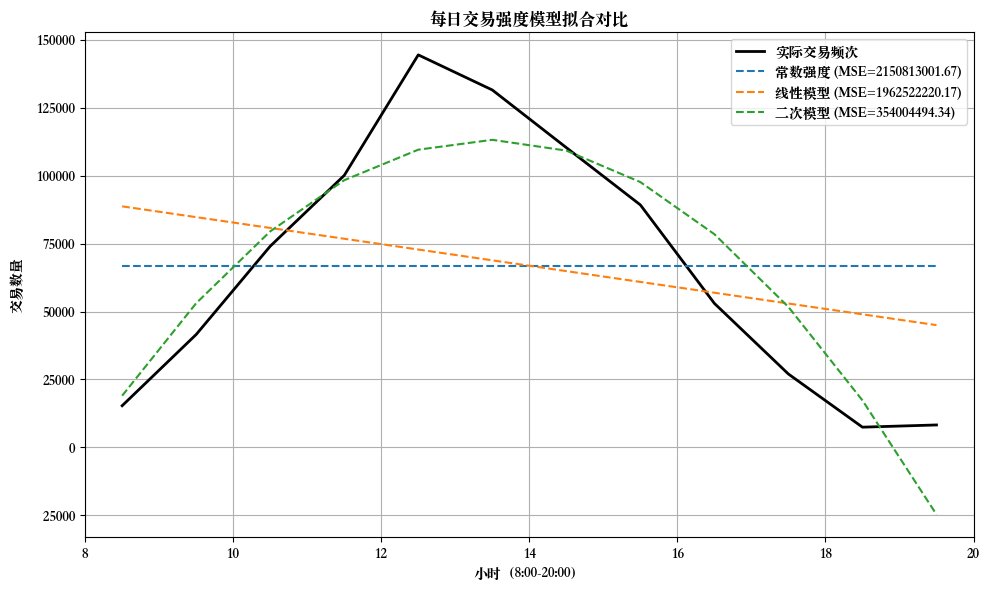

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# 提取“小时”+“分钟”的连续小时数
df['HourOfDay'] = df['InvoiceDate'].dt.hour + df['InvoiceDate'].dt.minute / 60.0

# 只保留8点到20点的销售时间数据
df = df[(df['HourOfDay'] >= 8) & (df['HourOfDay'] < 20)]

# 聚合为每小时的交易数量，小时区间改成8~20
hour_bins = np.arange(8, 21)  # 注意这里21是上界，包含20点整
hour_counts, _ = np.histogram(df['HourOfDay'], bins=hour_bins)
hour_midpoints = hour_bins[:-1] + 0.5


# === 模型 A: 常数强度 ===
lambda_const = np.mean(hour_counts)
const_pred = np.full_like(hour_counts, fill_value=lambda_const)

# === 模型 B: 线性强度 ===
X_linear = sm.add_constant(hour_midpoints)
model_linear = sm.OLS(hour_counts, X_linear).fit()
linear_pred = model_linear.predict(X_linear)

# === 模型 C: 二次强度 ===
X_quad = sm.add_constant(np.column_stack((hour_midpoints, hour_midpoints ** 2)))
model_quad = sm.OLS(hour_counts, X_quad).fit()
quad_pred = model_quad.predict(X_quad)

# === 误差对比 ===
mse_const = mean_squared_error(hour_counts, const_pred)
mse_linear = mean_squared_error(hour_counts, linear_pred)
mse_quad = mean_squared_error(hour_counts, quad_pred)

# === 可视化 ===
plt.figure(figsize=(10, 6))
plt.plot(hour_midpoints, hour_counts, label='实际交易频次', color='black', linewidth=2)
plt.plot(hour_midpoints, const_pred, '--', label=f'常数强度 (MSE={mse_const:.2f})')
plt.plot(hour_midpoints, linear_pred, '--', label=f'线性模型 (MSE={mse_linear:.2f})')
plt.plot(hour_midpoints, quad_pred, '--', label=f'二次模型 (MSE={mse_quad:.2f})')
plt.xlim(8, 20)
plt.xlabel("小时（8:00-20:00）")
plt.ylabel("交易数量")
plt.title("每日交易强度模型拟合对比")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()